In [0]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import pandas as pd
from tensorflow.python.lib.io import file_io
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD
from keras.callbacks import TensorBoard, ReduceLROnPlateau, EarlyStopping, Callback
from google.colab.patches import cv2_imshow
import h5py
import cv2
import os
from tqdm import tqdm
from random import shuffle

In [0]:
classes = 6
img_height = 150
img_width = 150
epochs_all_layers = 100
batch_size = 32

In [0]:
file_paths = ["drive/My Drive/Data/Agricultural","drive/My Drive/Data/Airport","drive/My Drive/Data/Baseball","drive/My Drive/Data/Beach","drive/My Drive/Data/Bridge","drive/My Drive/Data/Buildings"]
training_data = []
label = -1
for file_path in file_paths:
  label = label + 1
  for img in tqdm(os.listdir(file_path)):
    path = os.path.join(file_path,img)
    image = cv2.imread(path)
    image = cv2.resize(image, (img_height, img_width))
    training_data.append([np.array(image),np.array(label)])

100%|██████████| 100/100 [00:46<00:00,  2.15it/s]


In [0]:
dataset = training_data
dataset = np.array(dataset)
features = dataset[:, 0]
labels = dataset[:, 1]
labels_one_hot_encoded = to_categorical(labels, classes)

In [0]:
feature =[]
for i in range(len(features)):
    feature.append(features[i])

features = np.asarray(feature)


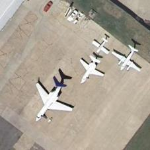

[0. 1. 0. 0. 0. 0.]


In [0]:
cv2_imshow(x_train[200])
print(y_train[200])

In [0]:
model = InceptionV3(include_top = False,weights = 'imagenet',input_shape=(img_height,img_width,3))
model.layers.pop()

model.outputs = [model.layers[-2].output]

model=Model(model.input,model.outputs)
print(model.summary())
newfeatures=model.predict(features)
#features_test=model.predict(test_img)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_659 (Conv2D)             (None, 74, 74, 32)   864         input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_659 (BatchN (None, 74, 74, 32)   96          conv2d_659[0][0]                 
__________________________________________________________________________________________________
activation_659 (Activation)     (None, 74, 74, 32)   0           batch_normalization_659[0][0]    
__________________________________________________________________________________________________
conv2d_660

In [0]:
print(newfeatures.shape)
print(features.shape)

(600, 3, 3, 768)
(600, 150, 150, 3)


In [0]:
x_train, X_test, y_train, Y_test= train_test_split(newfeatures, labels_one_hot_encoded, test_size = 0.30, stratify = labels_one_hot_encoded)

In [0]:
x1=x_train[:140,:,:,:]
x2=x_train[140:280,:,:,:]
x3=x_train[280:420,:,:,:]
print(x1.shape)
print(x2.shape)
print(x3.shape)
y1=y_train[:140,:]
y2=y_train[140:280,:]
y3=y_train[280:420,:]

(140, 3, 3, 768)
(140, 3, 3, 768)
(140, 3, 3, 768)


In [0]:
import numpy as np
from keras.datasets import mnist
from keras.models import Model,Sequential,load_model
from keras.layers.core import Dense, Dropout, Activation,Layer
from keras.layers import Input
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix
from keras.callbacks import ModelCheckpoint

from matplotlib import pyplot as plt
from matplotlib import style
import tensorflow as tf 



#Over first dataset
X_train=x1
Y_train=y1
X_train = X_train.reshape(-1,6912)
X_test = X_test.reshape(-1,(6912))
X_train = X_train.astype("float64")
X_test = X_test.astype("float64")
print(X_train.shape)
X_train /= 255
X_test /= 255


input_img = Input(shape=(6912,))
# encoder 1
enc1 = Dense(256,activation='relu')(input_img)
# output with softmax prob.
decode1 = Dense(6912,activation='sigmoid')(enc1)
encoder1 = Model(input_img,enc1)
auto_enc1 = Model(input_img,decode1)
auto_enc1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
auto_enc1.fit(X_train,X_train,epochs=50,batch_size=128)

encoder1.save('Encoder1')
input1 = encoder1.predict(X_train)


input_img = Input(shape=(input1.shape[1],))
# encoder 2
enc1 = Dense(128,activation='relu')(input_img)
# output with softmax prob.
decode1 = Dense(input1.shape[1],activation='sigmoid')(enc1)
encoder2 = Model(input_img,enc1)
auto_enc2 = Model(input_img,decode1)
auto_enc2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
auto_enc2.fit(input1,input1,epochs=50,batch_size=128)

encoder2.save('Encoder2')
input2 = encoder2.predict(input1)

# this is the combined model with a softmax layer to fine tune the weights.
final1 = Sequential()
x = load_model('Encoder1')
final1.add(x)
x = load_model('Encoder2')
final1.add(x)
final1.add(Dense(6,activation='softmax'))
final1.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])  
final1.fit(X_train, Y_train, epochs=50,batch_size=128,validation_data = (X_test,Y_test))






#Over second dataset
X_train=x2
Y_train=y2
X_train = X_train.reshape(-1,6912)
X_test = X_test.reshape(-1,(6912))
X_train = X_train.astype("float64")
X_test = X_test.astype("float64")
print(X_train.shape)
X_train /= 255
X_test /= 255


input_img = Input(shape=(6912,))
# encoder 1
enc1 = Dense(256,activation='relu')(input_img)
# output with softmax prob.
decode1 = Dense(6912,activation='sigmoid')(enc1)
encoder1 = Model(input_img,enc1)
auto_enc1 = Model(input_img,decode1)
auto_enc1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
auto_enc1.fit(X_train,X_train,epochs=50,batch_size=128)

encoder1.save('Encoder1')
input1 = encoder1.predict(X_train)


input_img = Input(shape=(input1.shape[1],))
# encoder 2
enc1 = Dense(128,activation='relu')(input_img)
# output with softmax prob.
decode1 = Dense(input1.shape[1],activation='sigmoid')(enc1)
encoder2 = Model(input_img,enc1)
auto_enc2 = Model(input_img,decode1)
auto_enc2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
auto_enc2.fit(input1,input1,epochs=50,batch_size=128)

encoder2.save('Encoder2')
input2 = encoder2.predict(input1)

# this is the combined model with a softmax layer to fine tune the weights.
final2 = Sequential()
x = load_model('Encoder1')

final2.add(x)
x = load_model('Encoder2')
final2.add(x)
final2.add(Dense(6,activation='softmax'))

final2.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])  
final2.fit(X_train, Y_train, epochs=50,batch_size=128,validation_data = (X_test,Y_test))







#Over 3rd part
X_train=x3
Y_train=y3
X_train = X_train.reshape(-1,6912)
X_test = X_test.reshape(-1,(6912))
X_train = X_train.astype("float64")
X_test = X_test.astype("float64")
print(X_train.shape)
X_train /= 255
X_test /= 255


input_img = Input(shape=(6912,))
# encoder 1
enc1 = Dense(256,activation='relu')(input_img)
# output with softmax prob.
decode1 = Dense(6912,activation='sigmoid')(enc1)
encoder1 = Model(input_img,enc1)
auto_enc1 = Model(input_img,decode1)
auto_enc1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
auto_enc1.fit(X_train,X_train,epochs=50,batch_size=128)

encoder1.save('Encoder1')
input1 = encoder1.predict(X_train)


input_img = Input(shape=(input1.shape[1],))
# encoder 2
enc1 = Dense(128,activation='relu')(input_img)
# output with softmax prob.
decode1 = Dense(input1.shape[1],activation='sigmoid')(enc1)
encoder2 = Model(input_img,enc1)
auto_enc2 = Model(input_img,decode1)
auto_enc2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
auto_enc2.fit(input1,input1,epochs=50,batch_size=128)

encoder2.save('Encoder2')
input2 = encoder2.predict(input1)

# this is the combined model with a softmax layer to fine tune the weights.
final3 = Sequential()
x = load_model('Encoder1')

final3.add(x)
x = load_model('Encoder2')
final3.add(x)
final3.add(Dense(6,activation='softmax'))

final3.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])  
final3.fit(X_train, Y_train, epochs=50,batch_size=128,validation_data = (X_test,Y_test))


(140, 6912)
Epoch 1/50
140/140 [==============================] - 23s 163ms/step - loss: 0.6928 - acc: 0.1419
Epoch 2/50
140/140 [==============================] - 0s 302us/step - loss: 0.6765 - acc: 0.2178
Epoch 3/50
140/140 [==============================] - 0s 268us/step - loss: 0.6119 - acc: 0.2656
Epoch 4/50
140/140 [==============================] - 0s 268us/step - loss: 0.4939 - acc: 0.2764
Epoch 5/50
140/140 [==============================] - 0s 249us/step - loss: 0.3620 - acc: 0.2771
Epoch 6/50
140/140 [==============================] - 0s 255us/step - loss: 0.2674 - acc: 0.2771
Epoch 7/50
140/140 [==============================] - 0s 281us/step - loss: 0.2300 - acc: 0.2771
Epoch 8/50
140/140 [==============================] - 0s 253us/step - loss: 0.2294 - acc: 0.2771
Epoch 9/50
140/140 [==============================] - 0s 253us/step - loss: 0.2372 - acc: 0.2771
Epoch 10/50
140/140 [==============================] - 0s 255us/step - loss: 0.2418 - acc: 0.2771
Epoch 11/50
140/

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Train on 140 samples, validate on 180 samples
Epoch 1/50
140/140 [==============================] - 25s 175ms/step - loss: 2.8627 - acc: 0.7238 - val_loss: 0.4664 - val_acc: 0.8333
Epoch 2/50
140/140 [==============================] - 0s 364us/step - loss: 2.0257 - acc: 0.7190 - val_loss: 0.4648 - val_acc: 0.8333
Epoch 3/50
140/140 [==============================] - 0s 293us/step - loss: 1.3359 - acc: 0.7750 - val_loss: 0.4636 - val_acc: 0.8333
Epoch 4/50
140/140 [==============================] - 0s 279us/step - loss: 1.2736 - acc: 0.7417 - val_loss: 0.4630 - val_acc: 0.8333
Epoch 5/50
140/140 [==============================] - 0s 279us/step - loss: 1.2591 - acc: 0.7298 - val_loss: 0.4630 - val_acc: 0.8333
Epoch 6/50
140/140 [==============================] - 0s 289us/step - loss: 1.0327 - acc: 0.7774 - val_loss: 0.4632 - val_acc: 0.8333
Epoch 7/50
140/140 [==============================] - 0s 339us/step - loss: 0.9322 - acc: 0.7964 - val_loss: 0.4633 - val_acc: 0.8333
Epoch 8/50
140/

In [0]:
probscore1=final1.predict_proba(X_test)
probscore2=final2.predict_proba(X_test)
probscore3=final3.predict_proba(X_test)


In [0]:
c = 0
ytrue=[]
ypred=[]
for i in range(len(probscore1)):
    probscore = [] 
    probscore.append(probscore1[i])
    probscore.append(probscore2[i])
    probscore.append(probscore3[i])
    overall = probscore[0]+probscore[1]+probscore[2]
    
    final_probscore = np.argmax(overall)
    ytrue.append(np.argmax(Y_test[i]))
    ypred.append(final_probscore)
    if Y_test[i][final_probscore]==1:
      c=c+1

print((c/len(probscore1))*100)